In [1]:
from collections import defaultdict
import re
import pandas

In [2]:
evaluating = re.compile("Evaluating models_for_gan/cremmalab5\.?(?P<bw>nobw)?\.nfc-0\.(?P<score>\d+)\.mlmodel\s*")
test_file = re.compile("Testing ./test-microfilm-(?P<mss>\d+).txt (?P<mode>[\w\s]+)")
accuracy = re.compile("(?P<acc>[\d\.]+)%\s+Accuracy")
characters = re.compile("(?P<chr>\d+)\s+Characters")
errors = re.compile("(?P<chr>\d+)\s+Errors")


data = [
    ["Colorized", "Mode", "MSS", "Score", "Accuracy", 
     "Characters", "Errors", "SpacesErrors", "NonSpaceAccuracy"]
]

def register(*args):
    data.append(list(args))

    
with open("test-microfilm.log") as f:
    colorized = False
    score = None
    last_score = None
    for line in f:
        if evaluating.match(line):
            if score is not None:
                register(colorized, mode, mss, score, acc, chars, errs, spaces_error, (errs-spaces_error)/chars)
                last_score = bw, score
            bw, score = evaluating.findall(line)[0]
            mode = bw if bw else "bw"
            spaces_error = 0
        elif test_file.match(line):
            if score is not None:
                # New test files happen before Evaluating is called !
                register(colorized, mode, mss, score, acc, chars, errs, spaces_error, (errs-spaces_error)/chars)
                last_score = bw, score
                # Set score to None to not triger evaluating register
                score = None
            mss, _ = test_file.findall(line.strip())[0]
            #mode = mode if mode == "NOBW" else "BW"
        elif accuracy.match(line.strip()):
            acc = float(accuracy.findall(line.strip())[0])
        elif characters.match(line.strip()):
            chars = int(characters.findall(line.strip())[0])
        elif errors.match(line.strip()):
            errs = int(errors.findall(line.strip())[0])
        elif "Colorized" in line:
            if score is not None:
                # Before setting colorized to True, we register our model, as it would otherwise be registered 
                #  as Colorized = True, Evaluating being met after !
                register(colorized, mode, mss, score, acc, chars, errs, spaces_error, (errs-spaces_error)/chars)
                last_score = bw, score
                score = None
            colorized = True
        elif "SPACE" in line:
            spaces_error += int(line.split()[0])
            
register(colorized, mode, mss, score, acc, chars, errs, spaces_error, (errs-spaces_error)/chars)
    
print(len(data)-1)

90


In [3]:
df = pandas.DataFrame(data[1:], columns=data[0])

df.to_csv("data.csv")

#df.groupby(by="Colorized").plot.hist(y="Accuracy")
df.groupby(by=["Colorized", "Mode"]).count() // 3

df.groupby(by=["Colorized", "Mode", "Score"]).count()

MSS  Accuracy  Characters  Errors  SpacesErrors  \
Colorized Mode Score                                                    
False     bw   9421     3         3           3       3             3   
               9423     3         3           3       3             3   
               9424     3         3           3       3             3   
               9427     3         3           3       3             3   
               9429     3         3           3       3             3   
               9432     3         3           3       3             3   
               9436     3         3           3       3             3   
          nobw 9518     3         3           3       3             3   
               9519     3         3           3       3             3   
               952      3         3           3       3             3   
               9521     3         3           3       3             3   
               9523     3         3           3       3             3   
               9524     3         3           3       3             3   
               9527     3         3           3       3             3   
               953      3         3           3       3             3   
True      bw   9421     3         3           3       3             3   
               9423     3         3           3       3             3   
               9424     3         3           3       3             3   
               9427     3         3           3       3             3   
               9429     3         3           3       3             3   
               9432     3         3           3       3             3   
               9436     3         3           3       3             3   
          nobw 9518     3         3           3       3             3   
               9519     3         3           3       3             3   
               952      3         3           3       3             3   
               9521     3         3           3       3             3   
               9523     3         3           3       3             3   
               9524     3         3           3       3             3   
               9527     3         3           3       3             3   
               953      3         3           3       3             3   

                      NonSpaceAccuracy  
Colorized Mode Score                    
False     bw   9421                  3  
               9423                  3  
               9424                  3  
               9427                  3  
               9429                  3  
               9432                  3  
               9436                  3  
          nobw 9518                  3  
               9519                  3  
               952                   3  
               9521                  3  
               9523                  3  
               9524                  3  
               9527                  3  
               953                   3  
True      bw   9421                  3  
               9423                  3  
               9424                  3  
               9427                  3  
               9429                  3  
               9432                  3  
               9436                  3  
          nobw 9518                  3  
               9519                  3  
               952                   3  
               9521                  3  
               9523                  3  
               9524                  3  
               9527                  3  
               953                   3

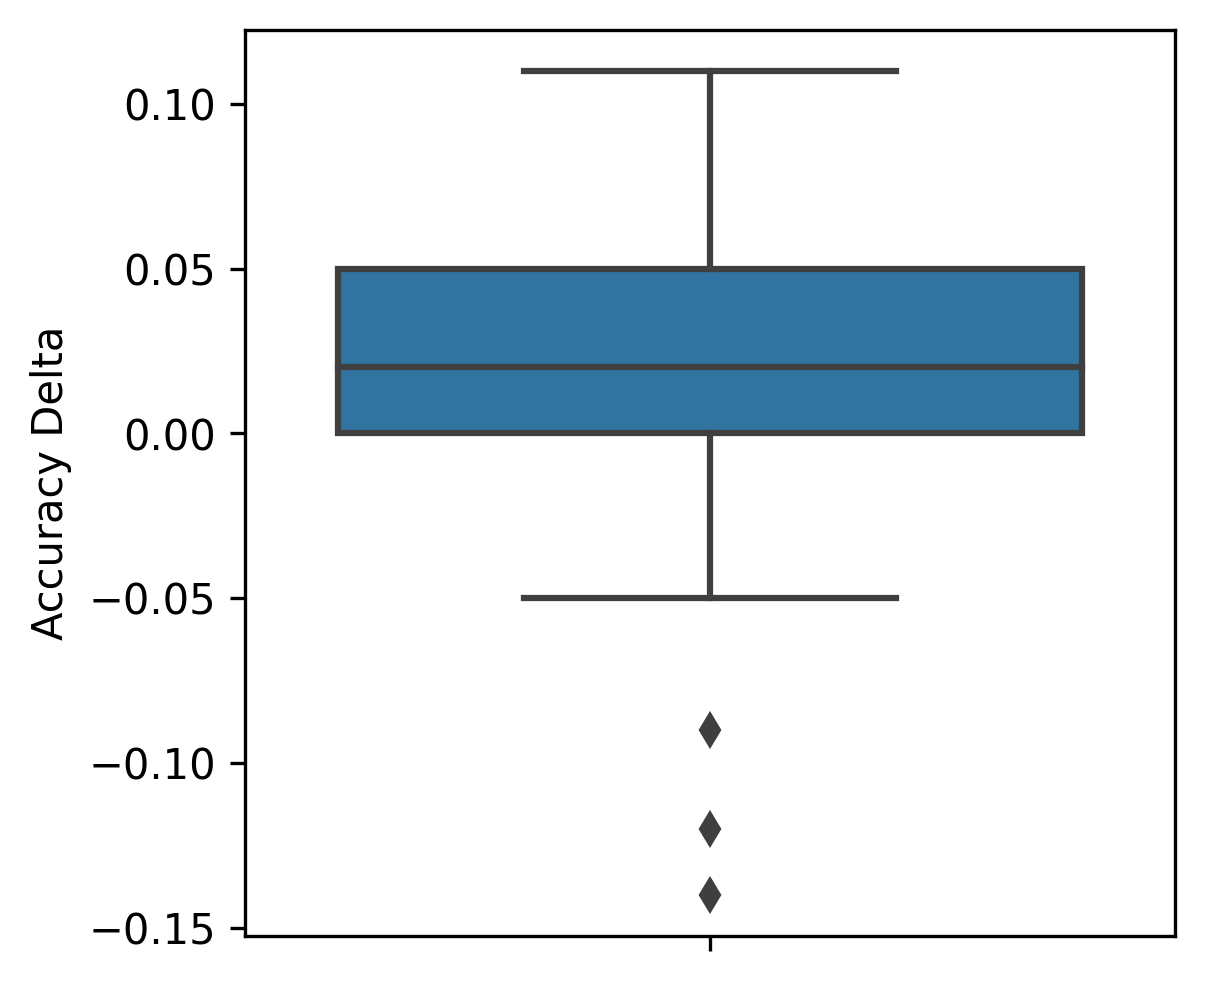

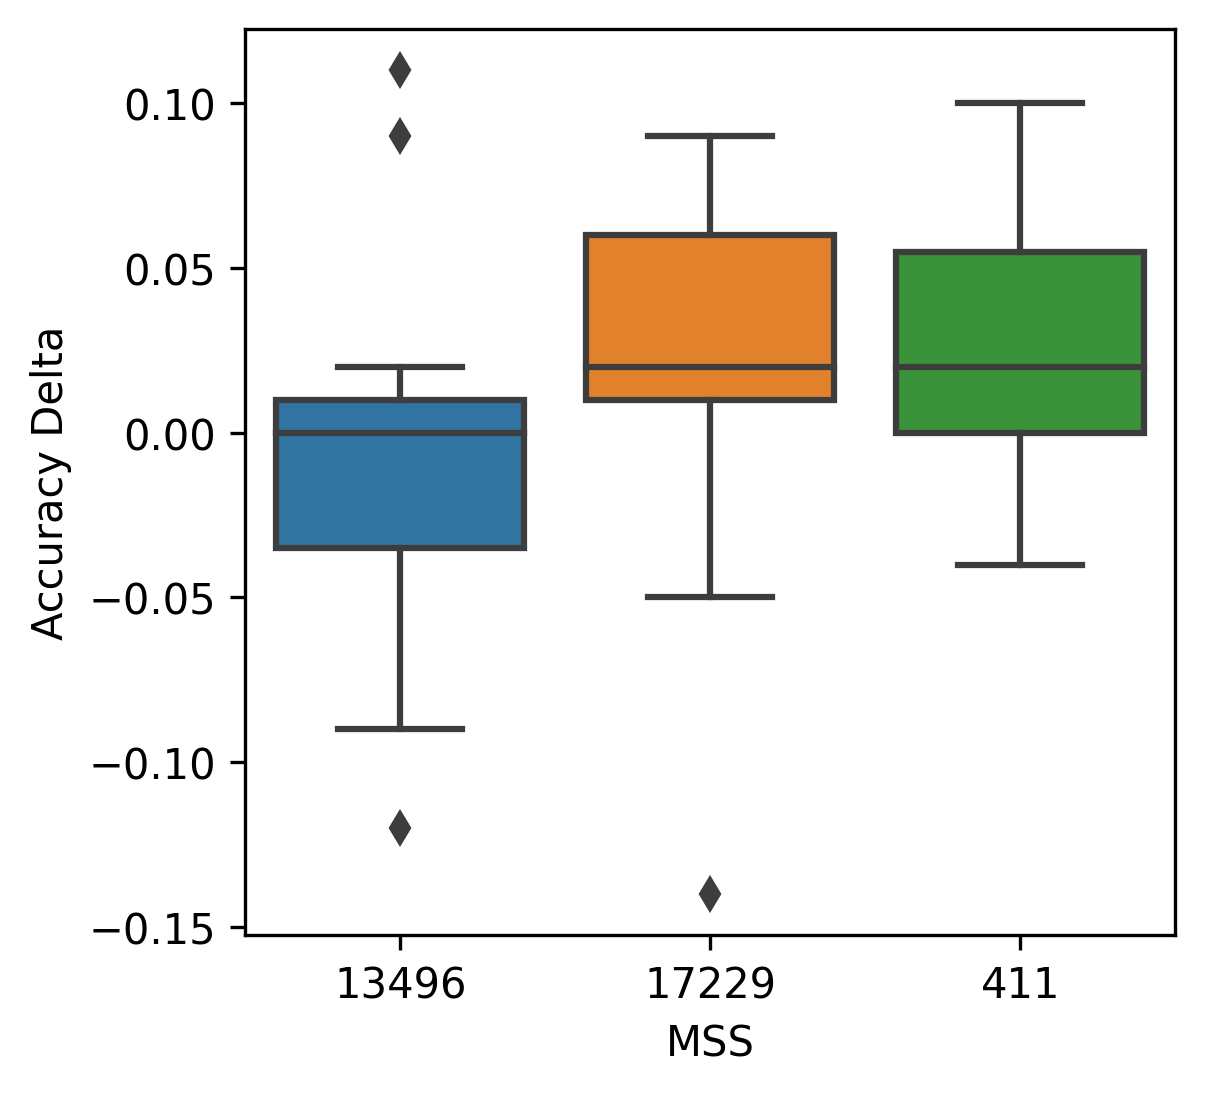

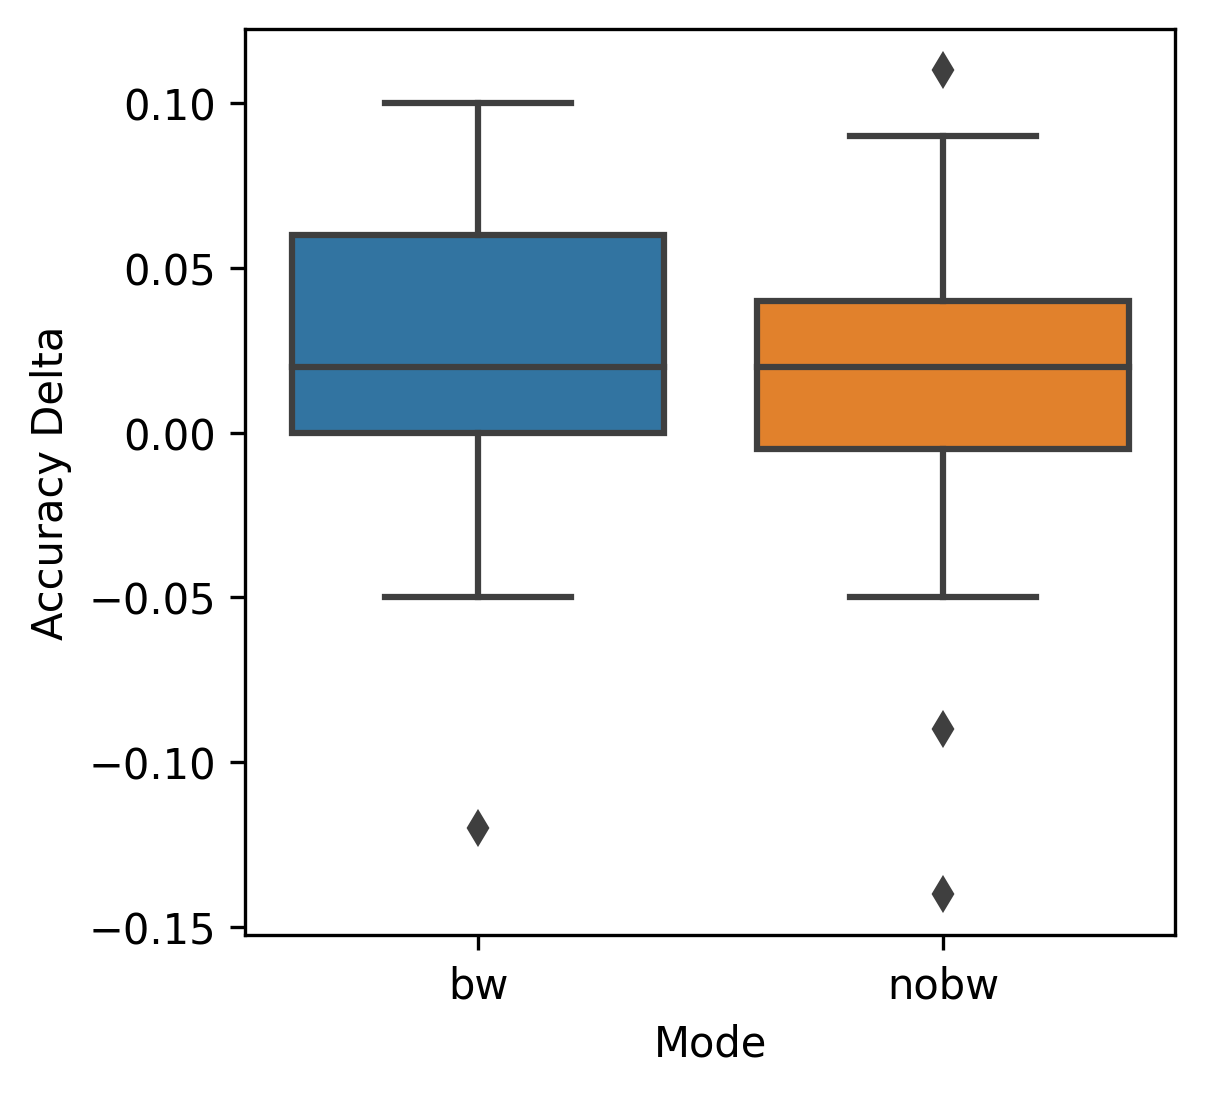

STD 0.05393598899705928,
Median 0.01999999999999602,
Mean 0.013333333333331945,
Runs 45


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



df_colorized = df[df["Colorized"] == True].sort_values(by=["Mode", "MSS", "Score"])["Accuracy"].astype(float)
df_microfilm = df[df["Colorized"] == False].sort_values(by=["Mode", "MSS", "Score"])["Accuracy"].astype(float)

accuracy_final = list(df_colorized.to_numpy() - df_microfilm.to_numpy())
recomposed_df = pandas.DataFrame([
    {"Accuracy Delta": a, "Mode": r.Mode, "MSS": r.MSS}
    for a, (_, r) in zip(accuracy_final, df[df["Colorized"] == False].sort_values(
        by=["Mode", "MSS", "Score"]).iterrows())
    ])

fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.boxplot(y="Accuracy Delta", data=recomposed_df, ax=ax)
plt.show()


fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.boxplot(y="Accuracy Delta", x="MSS", data=recomposed_df, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.boxplot(y="Accuracy Delta", x="Mode", data=recomposed_df, ax=ax)
plt.show()

print(f"STD {recomposed_df['Accuracy Delta'].std()},\n"
      f"Median {recomposed_df['Accuracy Delta'].median()},\n"
      f"Mean {recomposed_df['Accuracy Delta'].mean()},\n"
      f"Runs {len(recomposed_df)}")

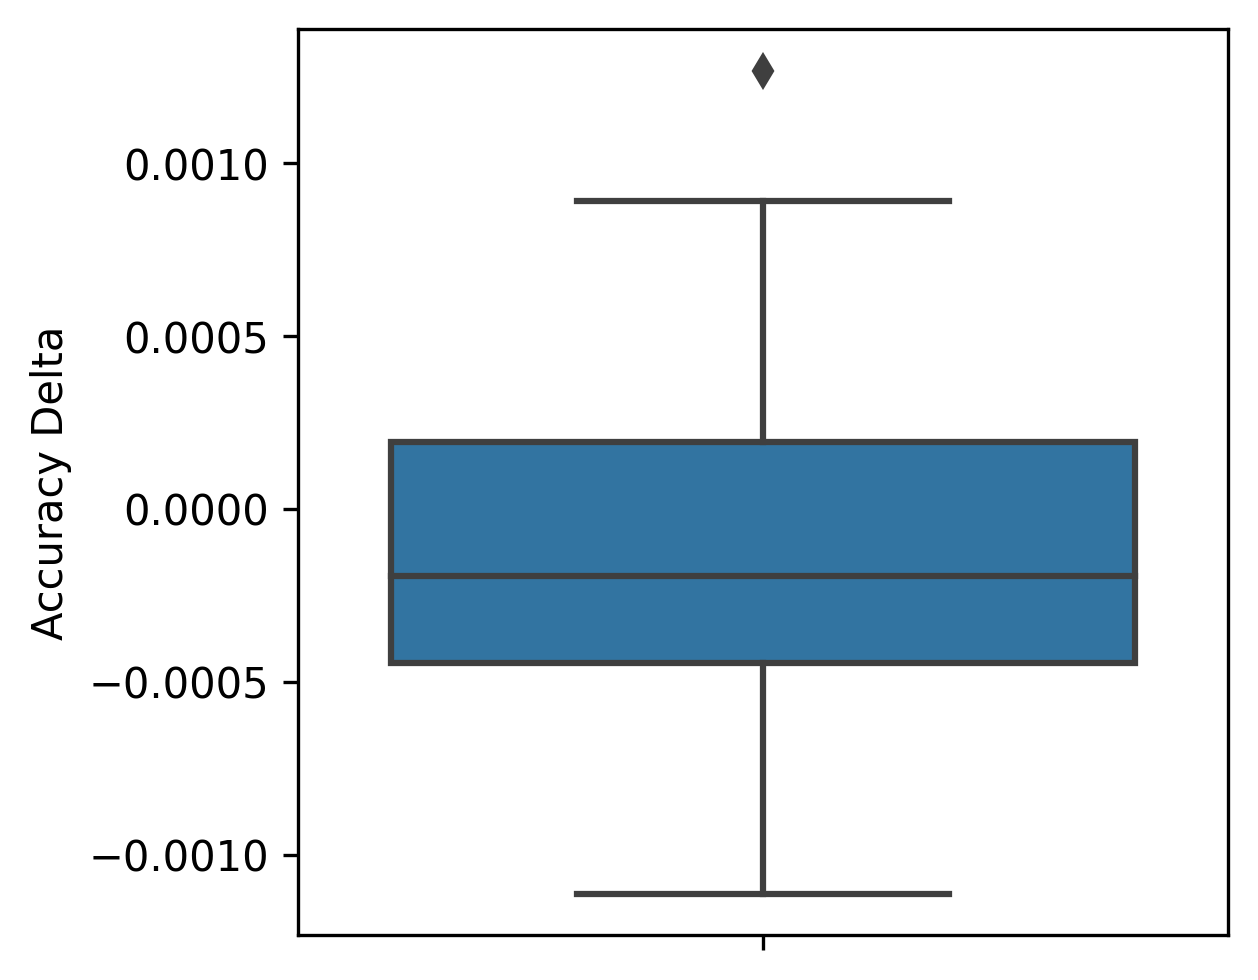

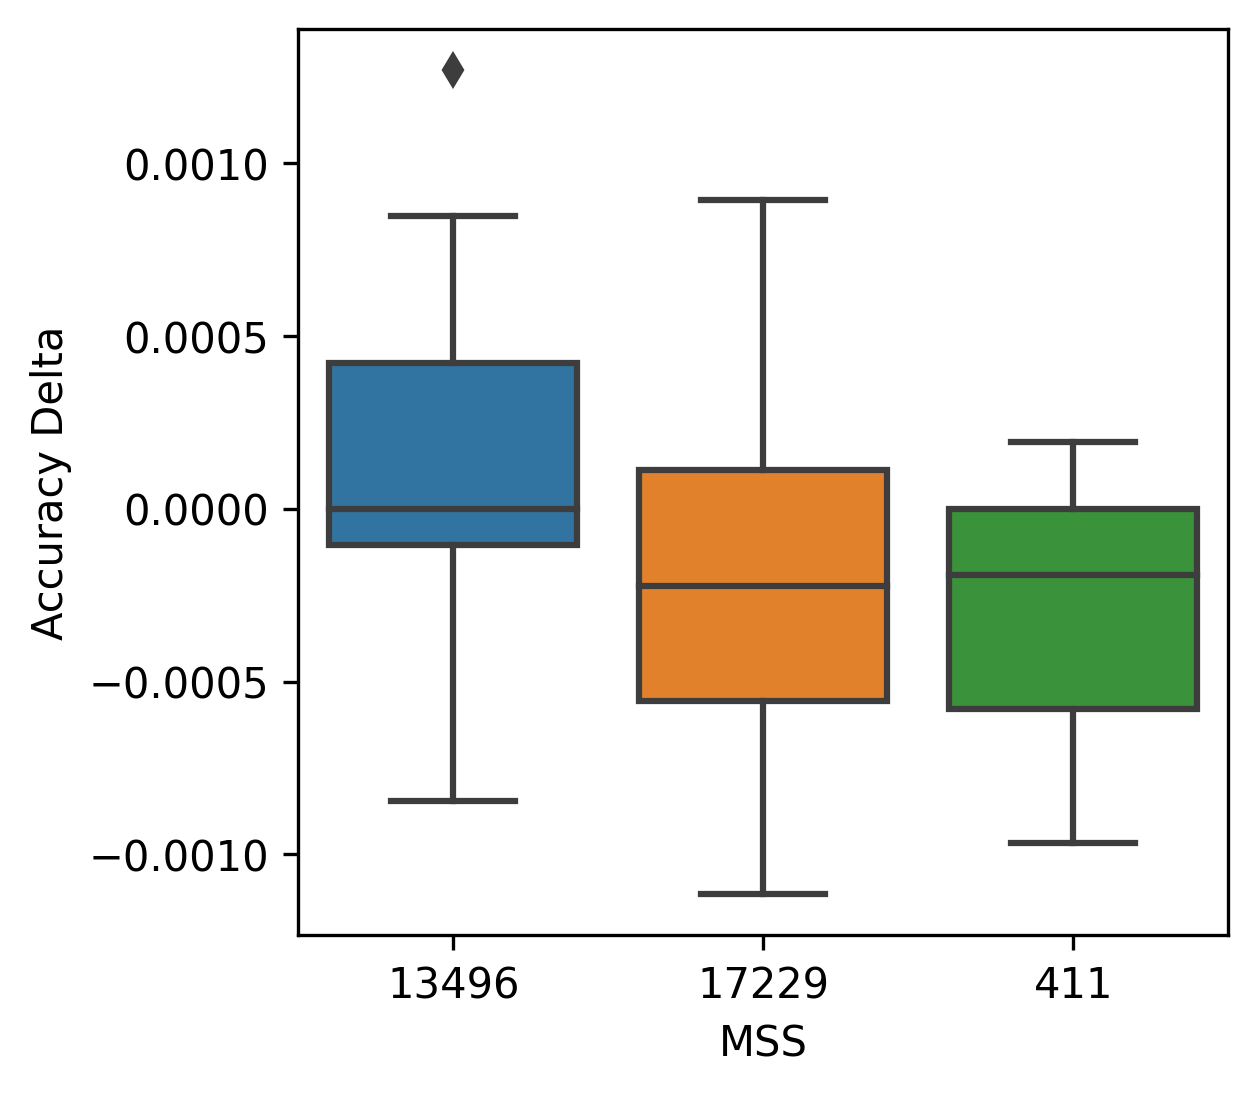

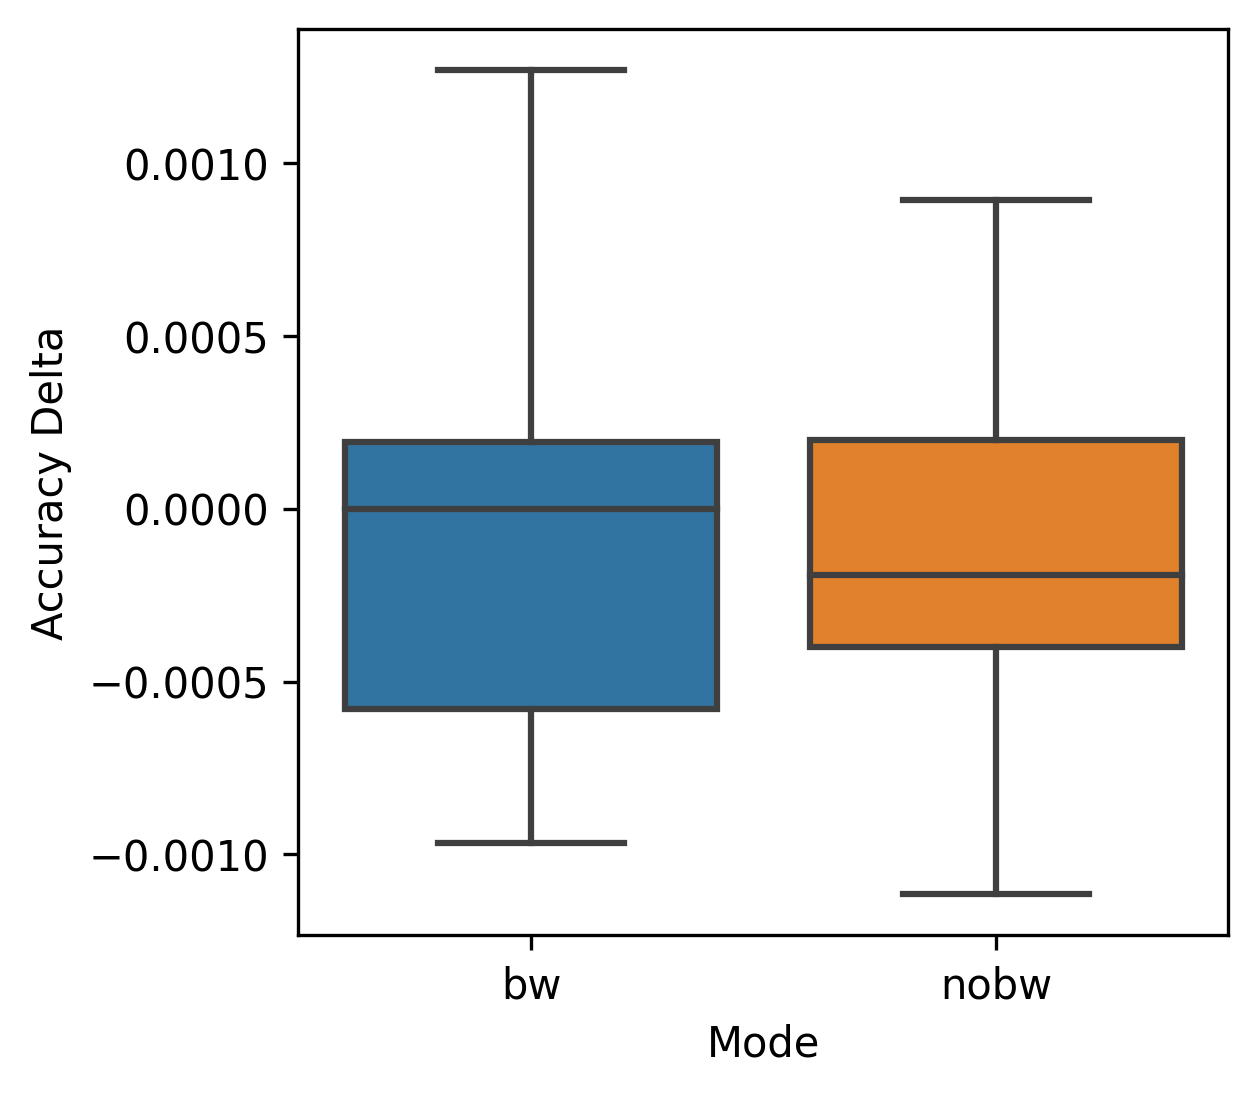

STD 0.0005122087446719473,
Median -0.00019319938176197426,
Mean -0.00012623574162596728,
Runs 45


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



df_colorized = df[df["Colorized"] == True].sort_values(by=["Mode", "MSS", "Score"])["NonSpaceAccuracy"].astype(float)
df_microfilm = df[df["Colorized"] == False].sort_values(by=["Mode", "MSS", "Score"])["NonSpaceAccuracy"].astype(float)

accuracy_final = list(df_colorized.to_numpy() - df_microfilm.to_numpy())
recomposed_df = pandas.DataFrame([
    {"Accuracy Delta": a, "Mode": r.Mode, "MSS": r.MSS}
    for a, (_, r) in zip(accuracy_final, df[df["Colorized"] == False].sort_values(
        by=["Mode", "MSS", "Score"]).iterrows())
    ])

fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.boxplot(y="Accuracy Delta", data=recomposed_df, ax=ax)
plt.show()


fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.boxplot(y="Accuracy Delta", x="MSS", data=recomposed_df, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.boxplot(y="Accuracy Delta", x="Mode", data=recomposed_df, ax=ax)
plt.show()

print(f"STD {recomposed_df['Accuracy Delta'].std()},\n"
      f"Median {recomposed_df['Accuracy Delta'].median()},\n"
      f"Mean {recomposed_df['Accuracy Delta'].mean()},\n"
      f"Runs {len(recomposed_df)}")